In [1]:
import numpy as np
import os
import json
import IPython.display as display
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

First, let's check to see if we have a reasonable number of houses that have images

In [2]:
with open('public_data_urls.txt','r') as F:
    for line in F:
        print(line)

https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_1.tar.gz



https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_2.tar.gz



https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_3.tar.gz



In [3]:
!wget https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_1.tar.gz

--2020-12-20 17:05:03--  https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_1.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.9.208, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12646460 (12M) [application/x-gzip]
Saving to: ‘dreamhouse_data_1.tar.gz’

dreamhouse_data_1.t 100%[===================>]  12.06M  3.23MB/s    in 3.7s    

2020-12-20 17:05:07 (3.23 MB/s) - ‘dreamhouse_data_1.tar.gz’ saved [12646460/12646460]



In [4]:
!wget https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_2.tar.gz

--2020-12-20 17:05:07--  https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_2.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.144, 172.217.7.208, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82549995 (79M) [application/x-gzip]
Saving to: ‘dreamhouse_data_2.tar.gz’

dreamhouse_data_2.t 100%[===================>]  78.73M  5.34MB/s    in 18s     

2020-12-20 17:05:25 (4.42 MB/s) - ‘dreamhouse_data_2.tar.gz’ saved [82549995/82549995]



In [5]:
!wget https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_3.tar.gz

--2020-12-20 17:05:26--  https://storage.googleapis.com/dreamhouse_emm2314/dreamhouse_data_3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.144, 172.217.7.208, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46975182 (45M) [application/x-gzip]
Saving to: ‘dreamhouse_data_3.tar.gz’

dreamhouse_data_3.t 100%[===================>]  44.80M  5.32MB/s    in 14s     

2020-12-20 17:05:40 (3.26 MB/s) - ‘dreamhouse_data_3.tar.gz’ saved [46975182/46975182]



In [6]:
!mkdir dreamhouse_data

In [7]:
import tarfile
for file in ['dreamhouse_data_1.tar.gz','dreamhouse_data_2.tar.gz','dreamhouse_data_3.tar.gz']:
    tar = tarfile.open(file)
    tar.extractall(path='dreamhouse_data/')

In [8]:
data_dirs = [d for d in os.listdir('dreamhouse_data/')]

In [9]:
num_houses_w_images = 0
for dd in data_dirs:
    houses_found = [d for d in os.listdir('dreamhouse_data/'+dd) if os.path.isdir('dreamhouse_data/{}/{}'.format(dd,d))]
    for house in houses_found:
        house_content = os.listdir('{}/{}'.format('dreamhouse_data/'+dd,house))
        if 'gsv_0.jpg' in house_content:
            num_houses_w_images +=1
print(num_houses_w_images)

1933


Great start. Let's make a way to grab the matching price annots and make a dataset

Let's check what the metadata looks like

In [10]:
with open('dreamhouse_data/{}/metadata.json'.format(data_dirs[7])) as test_md:
    md = json.load(test_md)

In [11]:
md['00000']

{'SALE TYPE': 'MLS Listing',
 'SOLD DATE': nan,
 'PROPERTY TYPE': 'Single Family Residential',
 'ADDRESS': '16 S Aberdeen St',
 'CITY': 'Arlington',
 'STATE OR PROVINCE': 'VA',
 'ZIP OR POSTAL CODE': 22204,
 'PRICE': 850000,
 'BEDS': 3,
 'BATHS': 2.0,
 'LOCATION': 'ARLINGTON FOREST',
 'SQUARE FEET': 1716,
 'LOT SIZE': 6385.0,
 'YEAR BUILT': 1940,
 'DAYS ON MARKET': 9,
 '$/SQUARE FEET': 495,
 'HOA/MONTH': nan,
 'STATUS': 'Active',
 'NEXT OPEN HOUSE START TIME': nan,
 'NEXT OPEN HOUSE END TIME': nan,
 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)': 'http://www.redfin.com/VA/Arlington/16-S-Aberdeen-St-22204/home/11258269',
 'SOURCE': 'BRIGHT MLS',
 'MLS#': 'VAAR170400',
 'FAVORITE': 'N',
 'INTERESTED': 'Y',
 'LATITUDE': 38.8664082,
 'LONGITUDE': -77.114769,
 'image_path': 'data/00000/gsv_0.jpg'}

In [12]:
paths = []
costs = []
years = []
beds = []
baths = []
for dd in data_dirs:
    houses_found = [d for d in os.listdir('dreamhouse_data/'+dd) if os.path.isdir('dreamhouse_data/{}/{}'.format(dd,d))]
    with open('dreamhouse_data/{}/metadata.json'.format(dd)) as test_md:
        md = json.load(test_md)
    for house in houses_found:
        house_content = os.listdir('dreamhouse_data/{}/{}'.format(dd,house))
        if 'gsv_0.jpg' in house_content:
            try:
                costs.append(md[house]['PRICE']/100000.)
                years.append(md[house]['YEAR BUILT'])
                beds.append(md[house]['BEDS'])
                baths.append(md[house]['BATHS'])
                paths.append('dreamhouse_data/{}/{}/gsv_0.jpg'.format(dd,house))
            except KeyError:
                print(house,dd)
print(len(paths))
print(len(costs))

00046 data_20176
00048 data_20176
00047 data_20176
00049 data_20176
00045 data_20176
1928
1928


In [13]:
print(paths[0],costs[0])

dreamhouse_data/data_22207/00028/gsv_0.jpg 10.95


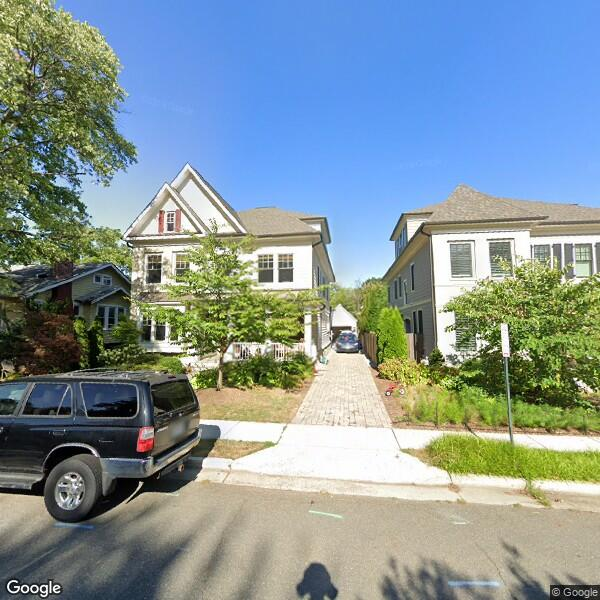

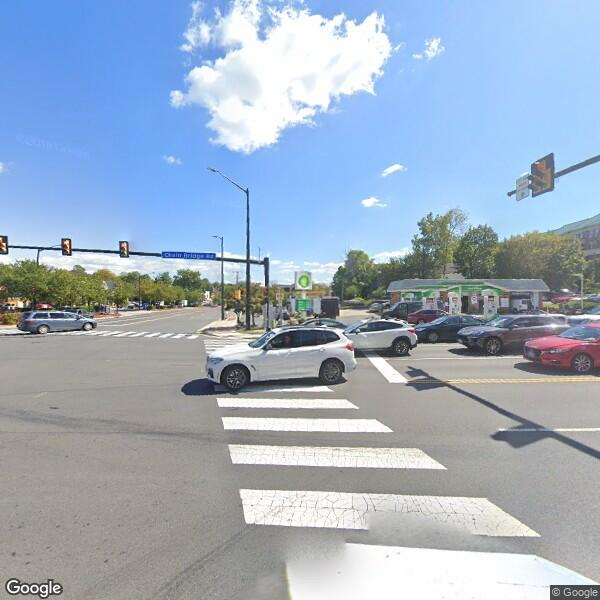

23.5

4.999



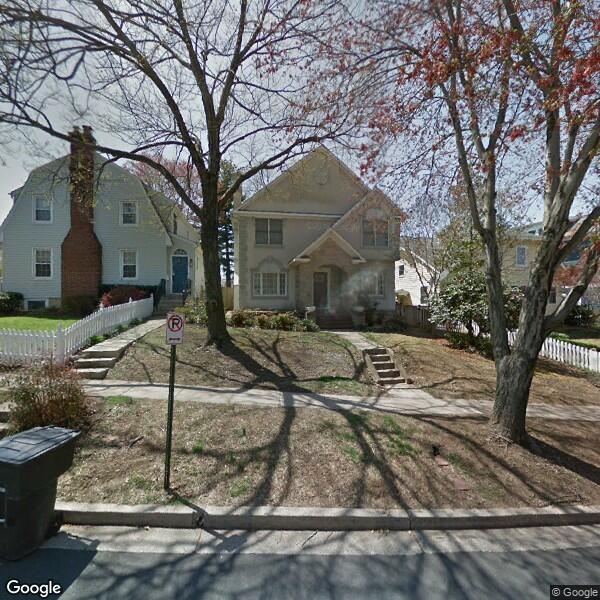

15.95



In [14]:
for n in range(3):
    choice = random.randint(0,len(paths))
    display.display(display.Image(paths[choice]))
    print(costs[choice])
    print()

In [15]:
numerical = list(zip(costs,years,beds,baths))

In [16]:
numerical[0]

(10.95, 1930, 3, 2.0)

In [17]:
IM_SIZE = 200

In [18]:
from sklearn.model_selection import train_test_split
train_paths,test_paths,train_labels,test_labels = train_test_split(paths,numerical,test_size=0.2)

In [19]:
train_paths,val_paths,train_labels,val_labels = train_test_split(train_paths,train_labels,test_size=0.15)

In [20]:
train_labels,train_years,train_beds,train_baths = list(zip(*train_labels))
val_labels,val_years,val_beds,val_baths = list(zip(*val_labels))
test_labels,test_years,test_beds,test_baths = list(zip(*test_labels))

In [21]:
def load_and_preprocess(path):
    im = tf.io.read_file(path)
    im = tf.image.decode_jpeg(im,channels=3)
    im = tf.image.resize(im,[IM_SIZE,IM_SIZE])
    im /= 255.0
    return im

In [22]:
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
image_ds = path_ds.map(load_and_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels,tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

for im,label in image_label_ds.take(2):
    print(im.shape,label)

(200, 200, 3) tf.Tensor(19, shape=(), dtype=int64)
(200, 200, 3) tf.Tensor(8, shape=(), dtype=int64)


In [23]:
train_ds = image_label_ds.shuffle(100)
train_ds = train_ds.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [24]:
path_ds_val = tf.data.Dataset.from_tensor_slices(val_paths)
image_ds_val = path_ds_val.map(load_and_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds_val = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels,tf.int64))
image_label_ds_val = tf.data.Dataset.zip((image_ds_val,label_ds_val))
val_ds = image_label_ds_val.shuffle(100)
val_ds = val_ds.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [25]:
path_ds_test = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds_test = path_ds_test.map(load_and_preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds_test = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels,tf.int64))
image_label_ds_test = tf.data.Dataset.zip((image_ds_test,label_ds_test))
test_ds = image_label_ds_test.shuffle(100)
test_ds = test_ds.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Let's think about what is a better predictor of cost: stats about the house (num beds, num baths, age) vs. appearance

We want to make sure the train/val/test split is the same for both the numerical and visual data, so let's build feature datasets that match the content of our image datasets above

In [26]:
train_dataset = pd.DataFrame({'yearbuilt':train_years,'beds':train_beds,'baths':train_baths,'cost':train_labels})
train_dataset = train_dataset.dropna()
val_dataset = pd.DataFrame({'yearbuilt':val_years,'beds':val_beds,'baths':val_baths,'cost':val_labels})
val_dataset = val_dataset.dropna()
test_dataset = pd.DataFrame({'yearbuilt':test_years,'beds':test_beds,'baths':test_baths,'cost':test_labels})
test_dataset = test_dataset.dropna()

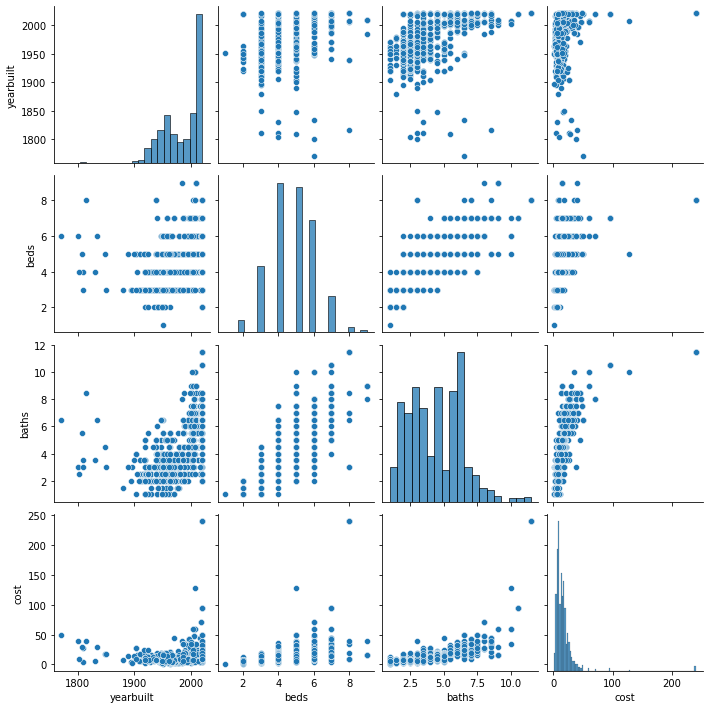

In [27]:
sns.pairplot(train_dataset[['yearbuilt','beds','baths','cost']])

In [28]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
yearbuilt,1984.95500,36.838755
beds,4.79250,1.268510
baths,4.43125,1.949012
cost,16.68025,19.343693


(array([1.033e+03, 1.460e+02, 1.000e+01, 4.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00]),
 array([  1.339 ,  25.2051,  49.0712,  72.9373,  96.8034, 120.6695,
        144.5356, 168.4017, 192.2678, 216.1339, 240.    ]),
 <BarContainer object of 10 artists>)

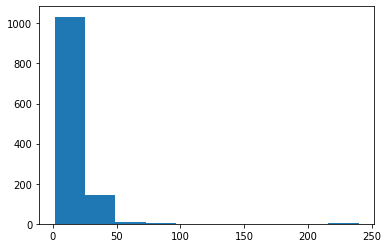

In [29]:
plt.hist(train_dataset['cost'])

In [30]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cost')
val_labels = val_features.pop('cost')
test_labels = test_features.pop('cost')

In [31]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(train_features.head())
print(np.array(train_features)[:5])
print(normalizer.mean.numpy())

   yearbuilt  beds  baths
0     1990.0     4    3.5
1     2003.0     4    4.5
2     2005.0     4    3.5
3     1930.0     4    2.5
4     1939.0     4    5.0
[[1990.     4.     3.5]
 [2003.     4.     4.5]
 [2005.     4.     3.5]
 [1930.     4.     2.5]
 [1939.     4.     5. ]]
[1984.955      4.7925     4.43125]


In [32]:
first = np.array(train_features[:1])
with np.printoptions(precision=2,suppress=True):
    print(first)
    print(normalizer(first).numpy())

[[1990.     4.     3.5]]
[[ 0.14 -0.63 -0.48]]


Let's see if we can just predict cost from number of bedrooms

In [33]:
bedrooms = np.array(train_features['beds'])
bed_normalizer = preprocessing.Normalization(input_shape=[1,])
bed_normalizer.adapt(bedrooms)

In [34]:
bed_model = tf.keras.Sequential([bed_normalizer,layers.Dense(units=1)])
bed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [35]:
bed_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error',metrics=['MAE'])
bed_linear_hist = bed_model.fit(train_features['beds'],train_labels,epochs=20,validation_data=(val_features['beds'],val_labels),verbose=0)

In [36]:
bed_hist = pd.DataFrame(bed_linear_hist.history)
bed_hist['epoch'] = bed_linear_hist.epoch
bed_hist.tail()

,loss,MAE,val_loss,val_MAE,epoch
15,6.650215,6.650215,6.000064,6.000064,15
16,6.649688,6.649688,5.999715,5.999715,16
17,6.647655,6.647655,6.000270,6.000270,17
18,6.648217,6.648217,5.999214,5.999214,18
19,6.649813,6.649813,6.000220,6.000220,19


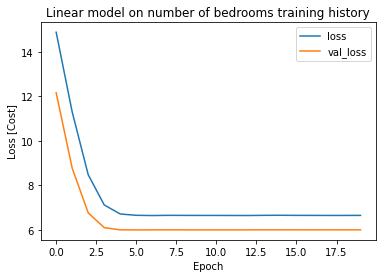

In [37]:
e_range = range(20)
plt.plot(e_range,bed_linear_hist.history['loss'], label='loss')
plt.plot(e_range,bed_linear_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Linear model on number of bedrooms training history')
plt.savefig('linear_beds_training.png')

In [38]:
from collections import defaultdict
test_results = defaultdict(dict)
test_results['bed_linear']['train'] = bed_model.evaluate(train_features['beds'],train_labels,verbose=0)
test_results['bed_linear']['val'] = bed_model.evaluate(val_features['beds'],val_labels,verbose=0)
test_results['bed_linear']['test'] = bed_model.evaluate(test_features['beds'],test_labels,verbose=0)

In [39]:
x = tf.linspace(0.0,10,101)
y = bed_model.predict(x)

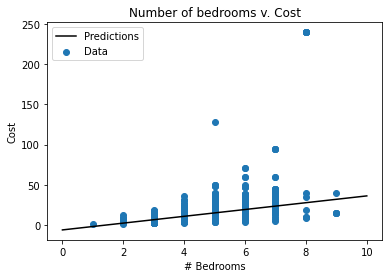

In [40]:
plt.scatter(train_features['beds'],train_labels,label='Data')
plt.plot(x,y,color='k',label='Predictions')
plt.xlabel('# Bedrooms')
plt.ylabel('Cost')
plt.legend()
plt.title('Number of bedrooms v. Cost')
plt.savefig('beds_v_cost_predictions.png')

In [41]:
linear_model = tf.keras.Sequential([normalizer,layers.Dense(units=1)])
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.95190465],
       [0.92796075],
       [0.4861009 ]], dtype=float32)>

In [42]:
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error',metrics=['MAE'])
lin_hist = linear_model.fit(train_features,train_labels,epochs=20,verbose=0,validation_data=(val_features,val_labels))

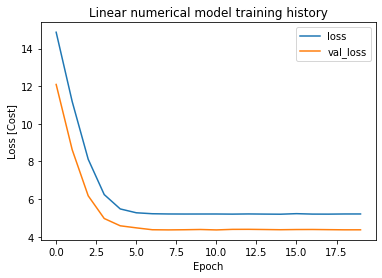

In [43]:
plt.plot(e_range,lin_hist.history['loss'], label='loss')
plt.plot(e_range,lin_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Linear numerical model training history')
plt.savefig('linear_all_training.png')

In [44]:
test_results['linear_all']['train'] = linear_model.evaluate(train_features,train_labels,verbose=0)
test_results['linear_all']['val'] = linear_model.evaluate(val_features,val_labels,verbose=0)
test_results['linear_all']['test'] = linear_model.evaluate(test_features,test_labels,verbose=0)

In [45]:
deeper_model = tf.keras.Sequential([normalizer,layers.Dense(64, activation='relu'),layers.Dense(64,activation='relu'),layers.Dense(1)])
deeper_model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
deeper_hist = deeper_model.fit(train_features,train_labels,epochs=20,verbose=0,validation_data=(val_features,val_labels))

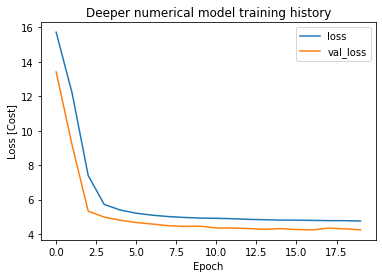

In [46]:
plt.plot(e_range,deeper_hist.history['loss'], label='loss')
plt.plot(e_range,deeper_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Deeper numerical model training history')
plt.savefig('deeper_numerical_training.png')

In [47]:
test_results['deeper_numerical']['train'] = deeper_model.evaluate(train_features,train_labels,verbose=0)
test_results['deeper_numerical']['val'] = deeper_model.evaluate(val_features,val_labels,verbose=0)
test_results['deeper_numerical']['test'] = deeper_model.evaluate(test_features,test_labels,verbose=0)

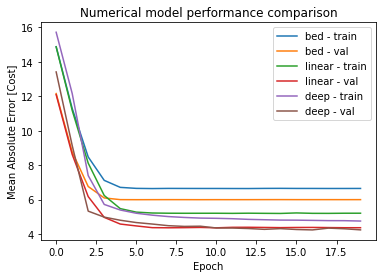

In [48]:
for train_hist,nm in [(bed_linear_hist.history,'bed'),(lin_hist.history,'linear'),(deeper_hist.history,'deep')]:
    plt.plot(e_range,train_hist['MAE'], label='{} - train'.format(nm))
    plt.plot(e_range,train_hist['val_MAE'],label='{} - val'.format(nm))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error [Cost]')
plt.legend()
plt.title('Numerical model performance comparison')
plt.savefig('num_model_mae.png')

## Data regression summary


A linear model between the number of bedrooms in a home and its cost provides reasonable results for a regression model, which logically tracks with our knowledge of home prices. Adding more variables (year built and number of bathrooms) to this linear model does not provide a model that is training well, which makes sense since we do not expect this relationship to be linear. Instead, we can see that by adding a Dense layer between these three numerical inputs and the predicted cost output, we can train a reasonable model that outperforms the linear one with one variable. Note that the validation loss is less than the training loss, which indicates that we may be overfitting.

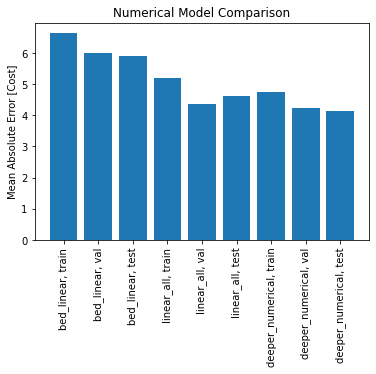

In [49]:
plotting_dict = {}
for k,v in test_results.items():
    plotting_dict['{}, train'.format(k)] = v['train'][0] 
    plotting_dict['{}, val'.format(k)] = v['val'][0] 
    plotting_dict['{}, test'.format(k)] = v['test'][0] 

plt.bar(plotting_dict.keys(),plotting_dict.values())
plt.xticks(rotation=90)
plt.ylabel('Mean Absolute Error [Cost]')
plt.title('Numerical Model Comparison')
plt.savefig('num_model_bar.png')

# Vision part

In [50]:
v_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IM_SIZE,IM_SIZE,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [51]:
v_model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
v_hist = v_model.fit(train_ds,epochs=50,validation_data=val_ds)

Epoch 1/50
41/41 [==============================] - 1s 14ms/step - loss: 29.0352 - MAE: 29.0352 - val_loss: 8.5561 - val_MAE: 8.5561
Epoch 2/50
41/41 [==============================] - 0s 11ms/step - loss: 9.0403 - MAE: 9.0403 - val_loss: 8.8539 - val_MAE: 8.8539
Epoch 3/50
41/41 [==============================] - 0s 12ms/step - loss: 8.9503 - MAE: 8.9503 - val_loss: 7.2206 - val_MAE: 7.2206
Epoch 4/50
41/41 [==============================] - 0s 12ms/step - loss: 7.5589 - MAE: 7.5589 - val_loss: 6.5950 - val_MAE: 6.5950
Epoch 5/50
41/41 [==============================] - 0s 12ms/step - loss: 7.0477 - MAE: 7.0477 - val_loss: 7.6070 - val_MAE: 7.6070
Epoch 6/50
41/41 [==============================] - 0s 12ms/step - loss: 7.9556 - MAE: 7.9556 - val_loss: 11.4740 - val_MAE: 11.4740
Epoch 7/50
41/41 [==============================] - 0s 12ms/step - loss: 8.0232 - MAE: 8.0232 - val_loss: 6.7925 - val_MAE: 6.7925
Epoch 8/50
41/41 [==============================] - 1s 12ms/step - loss: 7.3385

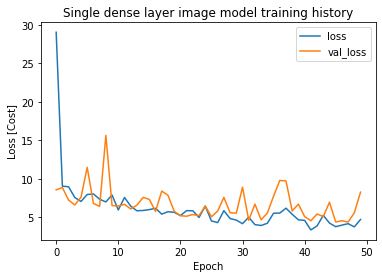

In [52]:
plt.plot(range(50),v_hist.history['loss'], label='loss')
plt.plot(range(50),v_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Single dense layer image model training history')
plt.savefig('dense1_training.png')

In [53]:
test_results['visual_single']['train'] = v_model.evaluate(train_ds,verbose=0)
test_results['visual_single']['val'] = v_model.evaluate(val_ds,verbose=0)
test_results['visual_single']['test'] = v_model.evaluate(test_ds,verbose=0)

In [54]:
deepv_model = models.Sequential()
deepv_model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(IM_SIZE,IM_SIZE,3)))
deepv_model.add(layers.MaxPooling2D((2,2)))
deepv_model.add(layers.Conv2D(32,(3,3),activation='relu'))
deepv_model.add(layers.MaxPooling2D((2,2)))
deepv_model.add(layers.Flatten())
deepv_model.add(layers.Dense(64,activation='relu'))
deepv_model.add(layers.Dense(1))
deepv_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4718656   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [55]:
deepv_model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
deepv_hist = deepv_model.fit(train_ds,epochs=50,validation_data=val_ds)

Epoch 1/50
41/41 [==============================] - 2s 40ms/step - loss: 9.1803 - MAE: 9.1803 - val_loss: 7.6975 - val_MAE: 7.6975
Epoch 2/50
41/41 [==============================] - 1s 33ms/step - loss: 8.0123 - MAE: 8.0123 - val_loss: 7.2890 - val_MAE: 7.2890
Epoch 3/50
41/41 [==============================] - 1s 33ms/step - loss: 7.3533 - MAE: 7.3533 - val_loss: 6.5411 - val_MAE: 6.5411
Epoch 4/50
41/41 [==============================] - 1s 32ms/step - loss: 6.5835 - MAE: 6.5835 - val_loss: 6.0185 - val_MAE: 6.0185
Epoch 5/50
41/41 [==============================] - 1s 33ms/step - loss: 5.9621 - MAE: 5.9621 - val_loss: 5.9753 - val_MAE: 5.9753
Epoch 6/50
41/41 [==============================] - 1s 30ms/step - loss: 4.9988 - MAE: 4.9988 - val_loss: 5.4385 - val_MAE: 5.4385
Epoch 7/50
41/41 [==============================] - 1s 29ms/step - loss: 4.5436 - MAE: 4.5436 - val_loss: 5.1991 - val_MAE: 5.1991
Epoch 8/50
41/41 [==============================] - 1s 30ms/step - loss: 4.3998 - M

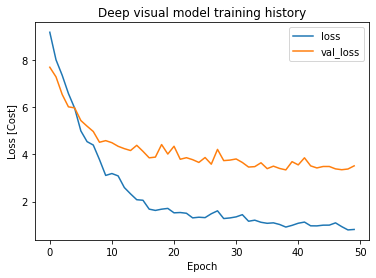

In [56]:
plt.plot(range(50),deepv_hist.history['loss'], label='loss')
plt.plot(range(50),deepv_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Deep visual model training history')
plt.savefig('deepv_training.png')

In [57]:
test_results['visual_deep']['train'] = deepv_model.evaluate(train_ds,verbose=0)
test_results['visual_deep']['val'] = deepv_model.evaluate(val_ds,verbose=0)
test_results['visual_deep']['test'] = deepv_model.evaluate(test_ds,verbose=0)

In [58]:
vgg = tf.keras.applications.VGG16(input_shape=(IM_SIZE,IM_SIZE,3),include_top=False,weights='imagenet')

In [59]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [60]:
vgg.trainable = False

In [61]:
ft = models.Sequential()
ft.add(vgg)
ft.add(layers.Flatten())
ft.add(layers.Dense(64,activation='relu'))
ft.add(layers.Dense(1))
ft.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1179712   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 15,894,465
Trainable params: 1,179,777
Non-trainable params: 14,714,688
_________________________________________________________________


In [62]:
ft.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['MAE'])
ft_hist = ft.fit(train_ds,epochs=50,validation_data=val_ds)

Epoch 1/50
41/41 [==============================] - 4s 100ms/step - loss: 7.7809 - MAE: 7.7809 - val_loss: 6.4685 - val_MAE: 6.4685
Epoch 2/50
41/41 [==============================] - 3s 73ms/step - loss: 6.1484 - MAE: 6.1484 - val_loss: 5.8983 - val_MAE: 5.8983
Epoch 3/50
41/41 [==============================] - 3s 76ms/step - loss: 5.5921 - MAE: 5.5921 - val_loss: 7.3545 - val_MAE: 7.3545
Epoch 4/50
41/41 [==============================] - 3s 74ms/step - loss: 5.3589 - MAE: 5.3589 - val_loss: 5.2372 - val_MAE: 5.2372
Epoch 5/50
41/41 [==============================] - 3s 77ms/step - loss: 4.5949 - MAE: 4.5949 - val_loss: 5.5890 - val_MAE: 5.5890
Epoch 6/50
41/41 [==============================] - 3s 74ms/step - loss: 4.4028 - MAE: 4.4028 - val_loss: 4.7858 - val_MAE: 4.7858
Epoch 7/50
41/41 [==============================] - 3s 73ms/step - loss: 3.7416 - MAE: 3.7416 - val_loss: 4.4617 - val_MAE: 4.4617
Epoch 8/50
41/41 [==============================] - 3s 74ms/step - loss: 3.6348 - 

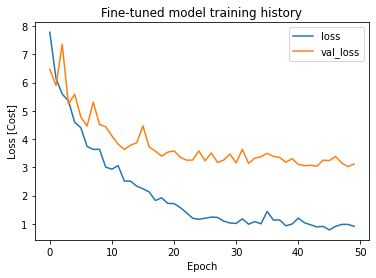

In [63]:
plt.plot(range(50),ft_hist.history['loss'], label='loss')
plt.plot(range(50),ft_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [Cost]')
plt.legend()
plt.title('Fine-tuned model training history')
plt.savefig('ft_training.png')

In [64]:
test_results['visual_ft']['train'] = ft.evaluate(train_ds,verbose=0)
test_results['visual_ft']['val'] = ft.evaluate(val_ds,verbose=0)
test_results['visual_ft']['test'] = ft.evaluate(test_ds,verbose=0)

Text(0.5, 1.0, 'Image model architecture comparison')

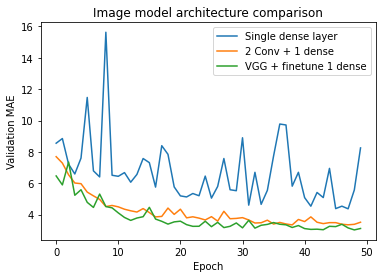

In [65]:
plt.plot(range(50),v_hist.history['val_MAE'], label='Single dense layer')
plt.plot(range(50),deepv_hist.history['val_MAE'],label='2 Conv + 1 dense')
plt.plot(range(50),ft_hist.history['val_MAE'],label='VGG + finetune 1 dense')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.legend()
plt.title('Image model architecture comparison')

## Compare numeric & visual models

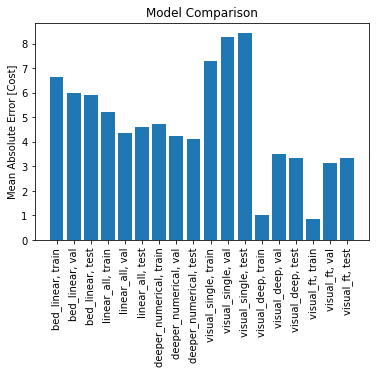

In [66]:
plotting_dict = {}
for k,v in test_results.items():
    plotting_dict['{}, train'.format(k)] = v['train'][0] 
    plotting_dict['{}, val'.format(k)] = v['val'][0] 
    plotting_dict['{}, test'.format(k)] = v['test'][0] 

plt.bar(plotting_dict.keys(),plotting_dict.values())
plt.xticks(rotation=90)
plt.ylabel('Mean Absolute Error [Cost]')
plt.title('Model Comparison')
plt.savefig('numandvis_model_bar.png')